# To Do

* Fix NaNs, especially in entry price
* Check if NSE option chain blank


In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import datetime
import mibian
import os
from bs4 import BeautifulSoup as bs
import pandas as pd
import zipfile
import io
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
# Run Plotly in offline mode
init_notebook_mode(connected=True)

In [2]:
###Automatic Data Cleaning starts
# Requires further refinement
from dateutil.parser import parse as date_parse

# Identify Floats
def is_float(inp):
    try:
        float(inp)
        return True
    except:
        return False

# Identify Ints
def is_int(inp):
    try:
        int(inp)
        return True
    except:
        return False

# Identify Dates
def is_date(inp):
    try:
        date_parse(inp)
        return True
    except:
        return False
    
#Clearning Function
def clean(inp):
    out = inp.strip()
    if(is_int(out)):
        out = int(out)
    elif(is_float(out)):
        out = float(out)
    return out
###Automatic Data Cleaning ends

# NSE Current Price Scraper
def get_current_price(symbol, instrument, expiry):
    # Convert input symbol string to uppercase
    symbol = symbol.upper()
    # Convert instrument type string to uppercase
    instrument = instrument.upper()
    # Convert expiry date string to uppercase
    expiry = expiry.upper()
    # Header of NSE website
    headers={'referer':"www.nseindia.com", 'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
    # Fetch source code of NSE Option Chain of given symbol, instrument and expiry
    req = requests.get("https://www.nseindia.com/live_market/dynaContent/live_watch/option_chain/optionKeys.jsp?segmentLink=17&instrument="+instrument+"&symbol="+symbol+"&date="+expiry, headers=headers)
    # Find price of underlying
    return float(str(bs(req.text).find('b',{'style':'font-size:1.2em;'})).split()[2][:-4])

# NSE Option Chain Scraper
def get_opt_chain(symbol, instrument, expiry):
    
    """symbol = nifty, banknifty, etc...;
        instrument = OPTIDX or OPTSTK;
        expiry = 19SEP2019 as a string"""
    
    # Convert input symbol string to uppercase
    symbol = symbol.upper()
    # Convert instrument type string to uppercase
    instrument = instrument.upper()
    # Convert expiry date string to uppercase
    expiry = expiry.upper()
            
    date = str(datetime.datetime.now().date()).replace('-', '_')
        
    if os.path.isfile('Data/'+symbol+instrument+expiry+date+'.csv'):
        opt_chain = pd.read_csv('Data/'+symbol+instrument+expiry+date+'.csv', index_col=0)
        underlying_price = opt_chain.iloc[-1][0]
        opt_chain = opt_chain.iloc[:-1]
        return underlying_price, opt_chain
    
    else:
        # Header of NSE website
        headers={'referer':"www.nseindia.com", 'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
        # Fetch source code of NSE Option Chain of given symbol, instrument and expiry
        req = requests.get("https://www.nseindia.com/live_market/dynaContent/live_watch/option_chain/optionKeys.jsp?segmentLink=17&instrument="+instrument+"&symbol="+symbol+"&date="+expiry, headers=headers)
        # Find price of underlying
        underlying_price = float(str(bs(req.text).find('b',{'style':'font-size:1.2em;'})).split()[2][:-4])
        # Find table in the source code 
        table = bs(req.text).find('table',{'id':'octable'})
        # Columns names for table
        columns = ['call_oi', 'call_change_in_oi', 'call_traded_volume', 'call_iv', 'call_ltp', 'call_net_change', "call_bid_quantity", "call_bid_price", 'call_ask_price', 'call_ask_quantity', 'strike', 'put_bid_quantity', 'put_bid_price', 'put_ask_price', 'put_ask_quantity', 'put_net_change', 'put_ltp', 'put_iv', 'put_traded_volume', 'put_change_in_oi', 'put_oi']
        # Empty list to store data
        data = []
        # Iterate over rows in the table...
        for row in table.findAll('tr')[2:]:
            # Clean data in row and append to list
            data.append(list(map(lambda x : clean(x.text), row.findAll('td')[1:-1])))
            # Fill blank values with NaN
            while('-' in data[-1]):
                data[-1][data[-1].index("-")] = float('nan')
        # Convert option chain to dataframe
        opt_chain = pd.DataFrame(data, columns=columns).iloc[:-1].applymap(lambda x: float(str(x).replace(',','')))
        # Add underlying price as last row
        opt_chain.loc[len(opt_chain)] = underlying_price        
        # Save option chain to csv
        opt_chain.to_csv('Data/'+symbol+instrument+expiry+date+'.csv')
        # Remove last column
        opt_chain = opt_chain.iloc[:-1]
        return underlying_price, opt_chain
        
# NSE Expiries Scraper
def get_expiries(symbol, instrument, expiry):   
    """symbol = nifty, banknifty, etc...;
        instrument = OPTIDX or OPTSTK;
        expiry = 19SEP2019 as a string"""
    
    # Convert input symbol string to uppercase
    symbol = symbol.upper()
    # Convert instrument type string to uppercase
    instrument = instrument.upper()
    # Convert expiry date string to uppercase
    expiry = expiry.upper()
    # Header of NSE website
    headers={'referer':"www.nseindia.com", 'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_10_1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/39.0.2171.95 Safari/537.36'}
    # Fetch source code of NSE Option Chain of given symbol, instrument and expiry
    req = requests.get("https://www.nseindia.com/live_market/dynaContent/live_watch/option_chain/optionKeys.jsp?segmentLink=17&instrument="+instrument+"&symbol="+symbol+"&date="+expiry, headers=headers)
    # Find expiry source code
    exp_src = bs(req.text).find('form',{'name':'ocForm'})
    # Empty list to store expiries
    expiry = []
    # Loop over source code to find expiry dates
    for exp in str(exp_src).split('value'):
        if exp[:2] == '="' and '</option>' in exp:
            # Append to list
            expiry.append(exp.split('"')[1])
    # Remove 'select' from list
    expiry.remove('select')
    # Return expiries
    return expiry


In [3]:
# Class for Trade Legs
class Leg():
    
    # Initialize object parameters
    def __init__(self, underlying, expiry, qty, opt_type, strike):
        # Option Expiry
        self.expiry = expiry.upper()
        # Option Quantity
        self.qty = qty
        # Option Type
        self.opt_type = opt_type
        # option Strike
        self.strike = strike
        # option Strike
        self.underlying = underlying.upper()
                
        if self.underlying == 'NIFTY' or self.underlying == 'BANKNIFTY' or self.underlying == 'NIFTYIT':
            self.instrument = 'optidx'.upper()
        else: self.instrument = 'optstk'.upper()
        
        day_of_exp = datetime.datetime.strptime(self.expiry, '%d%b%Y').date()
        today = datetime.datetime.now().date()
        dte = np.max([(day_of_exp - today).days,0]) + 0.000000001
        
        # Fetch Options Dataframe
        self.underlying_price, self.opt_df = get_opt_chain(self.underlying, self.instrument, self.expiry)

        # Split dataframe into self.calls and self.puts
        self.calls = self.opt_df[self.opt_df.columns[:11]].replace(np.nan, 0)
        self.puts = self.opt_df[self.opt_df.columns[10:]].replace(np.nan, 0)
        
        ### Fetch LTP & IV from option chains ###
        
        # If call option...
        if self.opt_type == 'C':
            # Locate LTP of corresponding call strike
            self.entry_price = float(self.calls[self.calls['strike'] == self.strike]['call_ltp'].iloc[0])
            # Create BS model for call option with price as input
            bs = mibian.BS([self.underlying_price, self.strike, 6.47, dte], callPrice = self.entry_price)
            # Compute IV
            self.iv = bs.impliedVolatility
            # Create BS model for call option with IV as input
            bs = mibian.BS([self.underlying_price, self.strike, 6.47, dte], volatility=self.iv)
            # Delta
            self.delta = bs.callDelta
            # Theta
            self.theta = bs.callTheta
            
        # If put option...
        elif self.opt_type == 'P':
            # Locate LTP of corresponding put strike
            self.entry_price = float(self.puts[self.puts['strike'] == self.strike]['put_ltp'].iloc[0])
            # Create BS model for put option with price as input
            bs = mibian.BS([self.underlying_price, self.strike, 6.47, dte], putPrice = self.entry_price)
            # IV
            self.iv = bs.impliedVolatility
            # Create BS model for put option with IV as input
            bs = mibian.BS([self.underlying_price, self.strike, 6.47, dte], volatility=self.iv)
            # Delta
            self.delta = bs.putDelta
            # Theta
            self.theta = bs.putTheta

        # Gamma
        self.gamma = bs.gamma
        # Vega
        self.vega = bs.vega

        # Get nearest expiry
        nearest_expiry = get_expiries(self.underlying, self.instrument, self.expiry)[0]
        
        # If selected expiry is nearest expiry...
        if self.expiry == nearest_expiry:
            # List of all Strikes in the chain
            self.strikes = list(self.calls['strike'])      
        # Else...
        else: 
            # Fetch Options Dataframe of Nearest Expiry
            throwaway_price, opt_nearest = get_opt_chain(self.underlying, self.instrument, self.expiry)
            # List of all Strikes in the chain
            self.strikes = list(opt_nearest['strike'])            
        
        # Underlying price Range
        self.underlying_range = pd.Series(self.strikes)
        
        # Greeks of Trade
        self.greeks = np.array([self.delta, self.gamma, self.theta, self.vega])*self.qty
    
    ### Compute Payoff at Expiry ###
    def compute_expiry_payoff(self):
        
        # If Call option...
        if self.opt_type == 'C':
            # If long self.calls...
            if self.qty > 0:
                # expiry_payoff = max(self.underlying_range- strike - premium, -premium) ???
                self.expiry_payoff = (self.underlying_range.apply(lambda x: mibian.BS([x, self.strike, 6.47, 0.00000001], volatility = self.iv).callPrice) - self.entry_price)*abs(self.qty)
            # If short self.calls...
            elif self.qty < 0:
                # expiry_payoff = min(- self.underlying_range+ strike + premium, premium) ???
                self.expiry_payoff = (self.entry_price - self.underlying_range.apply(lambda x: mibian.BS([x, self.strike, 6.47, 0.00000001], volatility = self.iv).callPrice))*abs(self.qty)
        # If Put option...
        elif self.opt_type == 'P':
            # If long self.puts...
            if self.qty > 0:
                # expiry_payoff = max(strike - self.underlying_range- premium, -premium) ???
                self.expiry_payoff = (self.underlying_range.apply(lambda x: mibian.BS([x, self.strike, 6.47, 0.00000001], volatility = self.iv).putPrice) - self.entry_price)*abs(self.qty)
            # If short self.puts...
            elif self.qty < 0:
                # expiry_payoff = min(- strike + self.underlying_range+ premium, premium) ???
                self.expiry_payoff = (self.entry_price - self.underlying_range.apply(lambda x: mibian.BS([x, self.strike, 6.47, 0.00000001], volatility = self.iv).putPrice))*abs(self.qty)

        return self.expiry_payoff
    
    ### Compute payoff on arbitrary day ###
    def compute_payoff(self, date=None, dte=None, iv_now=None):
        day_of_exp = datetime.datetime.strptime(self.expiry, '%d%b%Y').date()
        today = datetime.datetime.strptime(date, '%d%b%Y').date()
        dte = np.max([(day_of_exp - today).days,0]) + 0.000000001
        
        if iv_now == None:
            iv_now = self.iv
        
        # If Call option...
        if self.opt_type == 'C':
            # If long self.calls...
            if self.qty > 0:
                # payoff = max(self.underlying_range- strike - premium, -premium) ???
                self.payoff = (self.underlying_range.apply(lambda x: mibian.BS([x, self.strike, 6.47, dte], volatility = iv_now).callPrice) - self.entry_price)*abs(self.qty)
            # If short self.calls...
            elif self.qty < 0:
                # payoff = min(- self.underlying_range+ strike + premium, premium) ???
                self.payoff = (self.entry_price - self.underlying_range.apply(lambda x: mibian.BS([x, self.strike, 6.47, dte], volatility = iv_now).callPrice))*abs(self.qty)
        # If Put option...
        elif self.opt_type == 'P':
            # If long self.puts...
            if self.qty > 0:
                # payoff = max(strike - self.underlying_range- premium, -premium) ???
                self.payoff = (self.underlying_range.apply(lambda x: mibian.BS([x, self.strike, 6.47, dte], volatility = iv_now).putPrice) - self.entry_price)*abs(self.qty)
            # If short self.puts...
            elif self.qty < 0:
                # payoff = min(- strike + self.underlying_range+ premium, premium) ???
                self.payoff = (self.entry_price - self.underlying_range.apply(lambda x: mibian.BS([x, self.strike, 6.47, dte], volatility = iv_now).putPrice))*abs(self.qty)        

        # Set underlying price range as index
        self.payoff.index = self.underlying_range
        
        return self.payoff
        
    # Display Properties of Trade Leg
    def properties(self): print(self.expiry, self.qty, self.opt_type, self.strike, self.entry_price, self.iv)
        
    # Display Greeks of Trade Leg
    def display_greeks(self): print(self.delta, self.gamma, self.theta, self.vega)

In [4]:
# Input number of legs in trade
no_of_legs = 2

In [ ]:
# Get LTP
ltp = get_current_price('banknifty', 'optidx', '26Sep2020')

# Get Expiries
expiries = get_expiries('banknifty', 'optidx', '27Sep2020')

In [ ]:
# Define Trade Legs
leg1 = Leg('banknifty', '26Sep2019', -1, 'P', 30100)
leg2 = Leg('banknifty', '3Oct2019', 1, 'P', 30100)

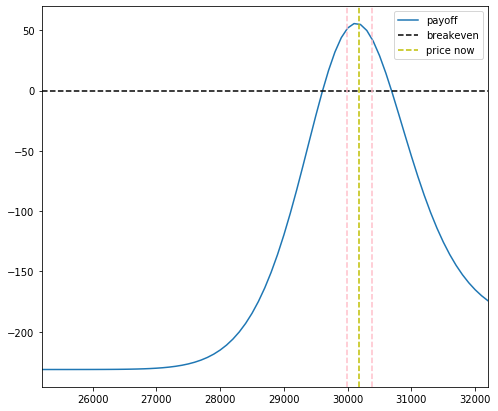

In [32]:
# Select date
date='25Sep2019'
iv = None

# Declare array to store leg payoffs
payoff = np.zeros(len(leg1.strikes))

# Iterate over legs and accumulate payoff
for x in range(no_of_legs):
    exec("payoff += leg%d.compute_payoff(date=date, iv_now=iv)" % (x+1))

payoff.dropna(inplace=True)

# Plot interactive payoff graph
payoff.plot(figsize=(8, 7))
plt.axhline(0, c='k', ls='--')
plt.axvline(ltp, c='y', ls='--')
plt.axvline(ltp+200, c='pink', ls='--')
plt.axvline(ltp-200, c='pink', ls='--')
plt.legend(['payoff', 'breakeven', 'price now'])

In [33]:
print('Max Profit:', round(payoff.max(), 2))
print('Max Loss  :', round(payoff.min(), 2))

Max Profit: 55.49
Max Loss  : -231.32


In [29]:
# Declare array to store leg greeks
greeks = np.zeros(len(leg1.greeks))

# Iterate over legs and accumulate greeks
for x in range(no_of_legs):
    exec("greeks += leg%d.greeks" % (x+1))


print('Delta: ', round(greeks[0],3))
print('Gamma: ', round(greeks[1],3))
print('Theta: ', round(greeks[2],3))
print('Vega:  ', round(greeks[3],3))

Delta:  -0.006
Gamma:  -0.0
Theta:  43.93
Vega:   9.936
